In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-geometric


Note: you may need to restart the kernel to use updated packages.


Using device: cpu
Data Preprocessing


/var/folders/l_/jv5qkh890p708wp1p4dmw80h0000gn/T/ipykernel_4340/2747003641.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index_tensor = torch.tensor(A.nonzero(), dtype=torch.long)


Splitting Data
Train data attributes: <bound method BaseData.keys of Data(x=[9923, 43], edge_index=[2, 1600338], num_nodes=9923, edge_label=[800169], edge_label_index=[2, 800169])>
Validation data attributes: <bound method BaseData.keys of Data(x=[9923, 43], edge_index=[2, 1600338], num_nodes=9923, edge_label=[200040], edge_label_index=[2, 200040])>
Test data attributes: <bound method BaseData.keys of Data(x=[9923, 43], edge_index=[2, 1800378], num_nodes=9923, edge_label=[200040], edge_label_index=[2, 200040])>
Initializing Model
Starting Model Training
Epoch: 010, Val AUC: 0.7037, Val AP: 0.6070
Epoch: 020, Val AUC: 0.7197, Val AP: 0.6258
Epoch: 030, Val AUC: 0.7418, Val AP: 0.6537
Epoch: 040, Val AUC: 0.7654, Val AP: 0.6863
Epoch: 050, Val AUC: 0.7875, Val AP: 0.7191
Epoch: 060, Val AUC: 0.8039, Val AP: 0.7447
Epoch: 070, Val AUC: 0.8138, Val AP: 0.7604
Epoch: 080, Val AUC: 0.8197, Val AP: 0.7700
Epoch: 090, Val AUC: 0.8229, Val AP: 0.7752
Epoch: 100, Val AUC: 0.8240, Val AP: 0.7770


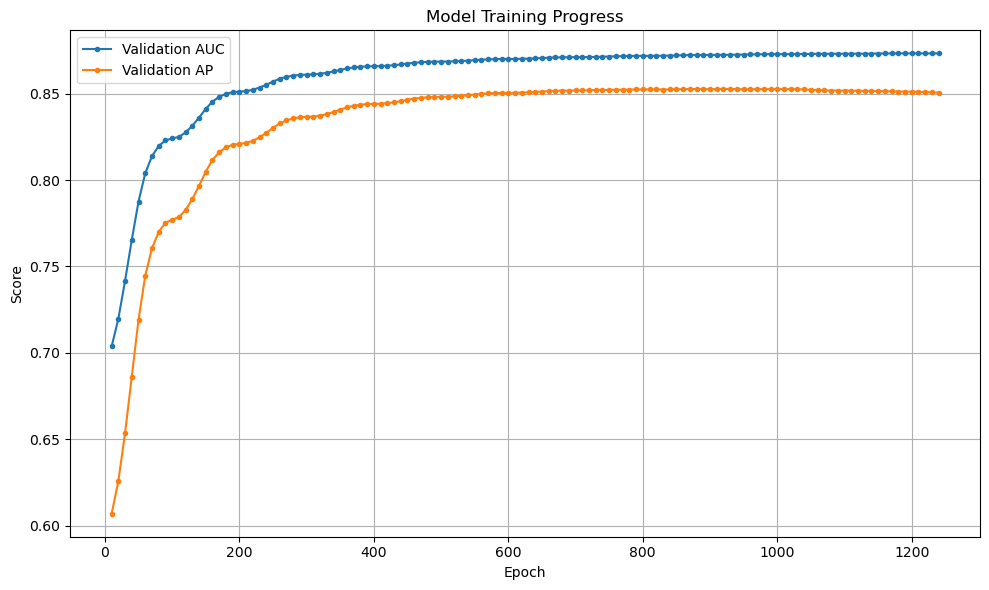

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from scipy.sparse import coo_matrix, bmat
import scipy.sparse as sp

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR # Import CyclicLR

from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GAE
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score

def preprocess_csv_to_graph(user_path, movie_path, rating_path):
    print("Data Preprocessing")

    users_df = pd.read_csv(user_path)
    movies_df = pd.read_csv(movie_path)
    ratings_df = pd.read_csv(rating_path)

    #Cleaning & Creating node mappings
    if 'Unnamed: 0' in users_df.columns:
        users_df = users_df.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in ratings_df.columns:
        ratings_df = ratings_df.drop(columns=['Unnamed: 0'])

    user_ids = sorted(users_df['UserID'].unique())
    movie_ids = sorted(movies_df['MovieID'].unique())
    num_users = len(user_ids)
    num_movies = len(movie_ids)

    user_id_map = {uid: i for i, uid in enumerate(user_ids)}
    movie_id_map = {mid: i for i, mid in enumerate(movie_ids)}

    #Process user features
    users_df = users_df.set_index('UserID').loc[user_ids].reset_index()

    gender_encoded = pd.get_dummies(users_df['Gender'], prefix='Gender')
    occupation_encoded = pd.get_dummies(users_df['Occupation'], prefix='Occ')
    scaler_age = StandardScaler()
    users_df['Age_scaled'] = scaler_age.fit_transform(users_df[['Age']])

    X_users = np.hstack([
        gender_encoded.to_numpy(),
        occupation_encoded.to_numpy(),
        users_df[['Age_scaled']].to_numpy()
    ])

    #Process movie features
    movies_df = movies_df.set_index('MovieID').loc[movie_ids].reset_index()

    movies_df['Year'] = movies_df['Title'].str.extract(r'\((\d{4})\)', expand=False)
    median_year = movies_df['Year'].dropna().astype(int).median()
    movies_df['Year'] = movies_df['Year'].fillna(median_year).astype(int)
    scaler_year = StandardScaler()
    movies_df['Year_scaled'] = scaler_year.fit_transform(movies_df[['Year']])

    movies_df['Genres_list'] = movies_df['Genres'].str.split('|')
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(movies_df['Genres_list'])

    X_movies = np.hstack([
        genres_encoded,
        movies_df[['Year_scaled']].to_numpy()
    ])

    #Combining both features
    X_users_padded = np.hstack([X_users, np.zeros((num_users, X_movies.shape[1]))])
    X_movies_padded = np.hstack([np.zeros((num_movies, X_users.shape[1])), X_movies])

    X = np.vstack([X_users_padded, X_movies_padded])
    X_tensor = torch.tensor(X, dtype=torch.float)

    #Graph edge index
    u_indices = ratings_df['UserID'].map(user_id_map).to_numpy()
    m_indices = ratings_df['MovieID'].map(movie_id_map).to_numpy()

    R = coo_matrix((np.ones(len(u_indices)), (u_indices, m_indices)),
                   shape=(num_users, num_movies))

    A = bmat([[None, R], [R.transpose(), None]], format='csr')

    edge_index_tensor = torch.tensor(A.nonzero(), dtype=torch.long)

    data = Data(x=X_tensor, edge_index=edge_index_tensor)
    data.num_nodes = X_tensor.shape[0]

    return data

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

@torch.no_grad()
def test(data, model):
    model.eval()
    z = model.encode(data.x, data.edge_index)

    # edge_label_index and edge_label for testing
    pos_edges = data.edge_label_index[:, data.edge_label == 1]
    neg_edges = data.edge_label_index[:, data.edge_label == 0]

    pos_scores = model.decode(z, pos_edges).cpu()
    neg_scores = model.decode(z, neg_edges).cpu()

    scores = torch.cat([pos_scores, neg_scores], dim=0)
    labels = torch.cat([
        torch.ones(pos_scores.shape[0]),
        torch.zeros(neg_scores.shape[0])
    ], dim=0)

    auc_score = roc_auc_score(labels, scores)
    ap_score = average_precision_score(labels, scores)

    return auc_score, ap_score

if __name__ == "__main__":

    USER_CSV_PATH = 'users.csv'
    MOVIE_CSV_PATH = 'movies_fixed.csv'
    RATING_CSV_PATH = 'ratings.csv'
 

    HIDDEN_DIM = 128
    EMBEDDING_DIM = 64

    LEARNING_RATE = 0.00001
    EPOCHS = 1500

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    full_data = preprocess_csv_to_graph(
        USER_CSV_PATH, MOVIE_CSV_PATH, RATING_CSV_PATH
    )


    print("Splitting Data")
    full_data = full_data.to('cpu')

    split_transform = RandomLinkSplit(
        is_undirected=True,
        num_val=0.1,
        num_test=0.1,
        add_negative_train_samples=False
    )

    train_data, val_data, test_data = split_transform(full_data)

    print("Train data attributes:", train_data.keys)
    print("Validation data attributes:", val_data.keys)
    print("Test data attributes:", test_data.keys)


    train_data = train_data.to(device)
    val_data = val_data.to(device)
    test_data = test_data.to(device)

    print("Initializing Model")
    num_features = full_data.num_features
    encoder = GCNEncoder(num_features, HIDDEN_DIM, EMBEDDING_DIM)
    model = GAE(encoder).to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    scheduler = CyclicLR(optimizer, base_lr=LEARNING_RATE*0.1, max_lr=LEARNING_RATE*10, step_size_up=50, cycle_momentum=False)

    epoch_logs = []
    val_auc_logs = []
    val_ap_logs = []

    # Early stopping parameters
    best_val_auc = 0
    patience = 5
    epochs_no_improve = 0
    best_model_state = None

    print("Starting Model Training")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        optimizer.zero_grad()

        z = model.encode(train_data.x, train_data.edge_index)

        # Extract positive and negative edge indices from train_data
        pos_edge_index = train_data.edge_label_index[:, train_data.edge_label == 1]
        neg_edge_index = train_data.edge_label_index[:, train_data.edge_label == 0]

        loss = model.recon_loss(z, pos_edge_index, neg_edge_index)


        loss.backward()
        optimizer.step()

        # Step the scheduler
        scheduler.step()

        if epoch % 10 == 0:
            val_auc, val_ap = test(val_data, model)
            print(f'Epoch: {epoch:03d}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')

            epoch_logs.append(epoch)
            val_auc_logs.append(val_auc)
            val_ap_logs.append(val_ap)

            # Early stopping check
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1

            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break




    print("--- Training Complete ---")

    # Load the best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model state.")

    print("Evaluating")
    test_auc, test_ap = test(test_data, model)
    print(f'Final Test Results: Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

    print("Saving Final Embeddings")
    model.eval()
    with torch.no_grad():
        final_z = model.encode(full_data.x.to(device), full_data.edge_index.to(device))

    final_embeddings_cpu = final_z.cpu().numpy()
    np.save('node_embeddings.npy', final_embeddings_cpu)
    print("Final node embeddings saved to 'node_embeddings.npy'")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_logs, val_auc_logs, marker='.', linestyle='-', label='Validation AUC')
    plt.plot(epoch_logs, val_ap_logs, marker='.', linestyle='-', label='Validation AP')

    plt.title('Model Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig('my_training_progress.png')
    print("Plot saved to my_training_progress.png")
